# Experiment - 1

In [32]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import copy
from prettytable import PrettyTable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.profiler import ProfilerActivity


from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor


from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split


import sys
from collections import Counter
import numpy as np
import time

from torchvision.models import resnet50, resnet101

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

from datetime import datetime
import plotly.graph_objects as go


from torch.utils.tensorboard import SummaryWriter

In [ ]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)

In [ ]:
def save_var_pickle(data, save_path, file_name):
    with open(save_path+"/"+file_name+".pkl", 'wb') as file:
    	pickle.dump(data, file)

In [ ]:
def grad_calc(grad):
    grad = torch.sum(torch.abs(grad)).detach().to("cpu").numpy()
    return grad

In [ ]:
def train(model, epochs, optimizer, scheduler, save_best_model=True, train_loader=None, test_loader = None,save_path='Models/best-model.pt', debug_grad= False):
    lowest_loss = np.inf
    losses = []
    val_acc = []
    grad_metrics = []
    for i in range(epochs):
        start_time = time.time()
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            with torch.profiler.profile(
                activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA, ProfilerActivity.XPU],
                record_shapes=True,
                profile_memory=True
            ) as prof:
                data = data.to(device)
                target = target.to(device)
        
                output = model(data)
        
                loss = loss_fn(output.squeeze(), target)

                if loss < lowest_loss and save_best_model:
                    print(save_best_model)
                    torch.save(model, save_path)
                    lowest_loss = loss
        
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                    
                for name, param in model.named_parameters():
                    if debug_grad:
                        print(name, torch.sum(torch.abs(param.grad)))
                    grad_metrics.append(grad_calc(param.grad))
                losses.append(loss.item())
        val_acc.append(test(model,1, test_loader))
        end_time = time.time()
        print("Epoch ",i," : \n Val Acc = ",test(model,1,test_loader), " Loss = ", losses[-1], "Epoch time = ", round(end_time - start_time, 3))
        scheduler.step()
    return losses, val_acc, prof, grad_metrics

In [ ]:
def multi_train(model, epochs, optimizer, scheduler,num_runs=1, save_best_model=False, train_loader=None, test_loader = None,save_path='Models/best-model.pt', debug_grad= False, save_comp_path=None):
    comp_loss = []
    comp_acc = []
    comp_prof = []
    comp_grad = []
    for i in range(num_runs):
        print("Run No : ", i+1)
        model_temp = copy.deepcopy(model)
        model_temp.to(device)
        
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model_temp.parameters(), lr=0.001)        
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        
        a,b,c,d = train(model_temp, epochs, optimizer, scheduler, save_best_model, train_loader, test_loader, save_path, debug_grad)
        
        comp_loss.append(a)
        comp_acc.append(b)
        comp_prof.append(c)
        comp_grad.append(d)
    if not save_comp_path is None:
        save_var_pickle(comp_loss, save_comp_path, "comp_loss")
        save_var_pickle(comp_acc, save_comp_path, "comp_acc")
        # save_var_pickle(comp_prof, save_comp_path, "comp_prof")
        save_var_pickle(comp_grad, save_comp_path, "comp_grad")
    return comp_loss, comp_acc, comp_prof, comp_grad

In [ ]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

def test(model, epoch, input_loader):
    model.eval()
    correct = 0
    for data, target in input_loader:

        data = data.to(device)
        target = target.to(device)

        try:
          output = model(data)
        except AttributeError as e:
          print(f"Error: {e}")
          continue


        pred = output.argmax(dim=-1)
        correct += number_of_correct(pred, target)

    return correct / len(input_loader.dataset)
    print(f"\nTest \tAccuracy: {correct}/{len(input_loader.dataset)} ({100. * correct / len(input_loader.dataset):.0f}%)\n")

In [ ]:
def get_expanded_weight_linear(inp_layer, reference_layer, expand_type='symmetric'):
    if len(inp_layer.weight.shape) > 2:
        out_size, inp_size = tuple(inp_layer.weight.shape)[:2]
    else:
        out_size, inp_size = tuple(inp_layer.weight.shape)
    layer = nn.Linear(inp_size, out_size)
    layer.weight = nn.Parameter(torch.zeros_like(layer.weight))
    ref_size = reference_layer.weight.shape
    r_factor = layer.weight.shape[0] / ref_size[0]
    c_factor = layer.weight.shape[1] / ref_size[1]

    # print(r_factor)
    # print(c_factor)
    # print(ref_size)
    # print(layer.weight.shape)

    assert r_factor == 1 or r_factor % 2 == 0, "Layer resizing should 1 or multiple of 2"
    assert c_factor == 1 or c_factor % 2 == 0, "Layer resizing should 1 or multiple of 2"
    methods = ['symmetric', 'noisy_symmetric', 'noisy_diagonal', 'diagonal']
    assert expand_type in methods, "Invalid method"

    if r_factor == 1 and c_factor == 1:
        return (layer.weight, layer.bias)

    r_factor = int(r_factor)
    c_factor = int(c_factor)

    # print(r_factor)
    # print(c_factor)

    
    if expand_type=='symmetric' or expand_type=='noisy_symmetric':
        with torch.no_grad():
            layer.weight = nn.Parameter(torch.zeros_like(layer.weight))
            for i in range(r_factor):
                noise = torch.rand_like(reference_layer.weight)
                for j in range(c_factor):

                    # Modify division by 2 for other cases, 4 fold, x-fold expansion
                    
                    if expand_type=='noisy_symmetric':
                        # print("adding noise")
                        # print((-1)**j)
                        layer.weight[i*ref_size[0]:(i+1)*ref_size[0], j*ref_size[1]:(j+1)*ref_size[1]] = reference_layer.weight / 2 + ((-1)**j) * noise 
                    else:
                        # print(layer.weight.shape)
                        layer.weight[i*ref_size[0]:(i+1)*ref_size[0], j*ref_size[1]:(j+1)*ref_size[1]] = reference_layer.weight / 2

                    layer.bias[i*ref_size[0]:(i+1)*ref_size[0]] = reference_layer.bias
    
    elif expand_type=="noisy_diagonal" or expand_type=="diagonal":
        with torch.no_grad():
            layer.weight = nn.Parameter(torch.zeros_like(layer.weight))
            for i in range(r_factor):
                noise = torch.rand_like(reference_layer.weight)
                for j in range(c_factor):
                    if expand_type=='noisy_diagonal':    
                        if i==j:
                            layer.weight[i*ref_size[0]:(i+1)*ref_size[0], j*ref_size[1]:(j+1)*ref_size[1]] = reference_layer.weight + ((-1)**j) * noise 
                        else:
                            layer.weight[i*ref_size[0]:(i+1)*ref_size[0], j*ref_size[1]:(j+1)*ref_size[1]] = ((-1)**j) * noise
                            # layer.weight[i*ref_size[0]:(i+1)*ref_size[0], j*ref_size[1]:(j+1)*ref_size[1]] = 0
                    
                    elif expand_type=='diagonal' and i==j:
                        layer.weight[i*ref_size[0]:(i+1)*ref_size[0], j*ref_size[1]:(j+1)*ref_size[1]] = reference_layer.weight

                    layer.bias[i*ref_size[0]:(i+1)*ref_size[0]] = reference_layer.bias
                    
    return (layer.weight, layer.bias)

In [ ]:
def get_expanded_weight_conv2d(inp_layer, reference_layer, expand_type='symmetric'):
    if len(inp_layer.weight.shape) > 2:
        out_size, inp_size = tuple(inp_layer.weight.shape)[:2]
    else:
        out_size, inp_size = tuple(inp_layer.weight.shape)
    layer = nn.Conv2d(inp_size, out_size, inp_layer.kernel_size[0])
    layer.weight = nn.Parameter(torch.zeros_like(layer.weight))
    ref_size = reference_layer.weight.shape
    r_factor = layer.weight.shape[0] / ref_size[0]
    c_factor = layer.weight.shape[1] / ref_size[1]

    # print(r_factor)
    # print(c_factor)
    # print(ref_size)
    # print(layer.weight.shape)

    assert r_factor == 1 or r_factor % 2 == 0, "Layer resizing should 1 or multiple of 2"
    assert c_factor == 1 or c_factor % 2 == 0, "Layer resizing should 1 or multiple of 2"
    
    methods = ['symmetric', 'noisy_symmetric', 'noisy_diagonal', 'diagonal']
    assert expand_type in methods, "Invalid method"
    
    if r_factor == 1 and c_factor == 1:
        return (layer.weight, layer.bias)

    r_factor = int(r_factor)
    c_factor = int(c_factor)

    # print(r_factor)
    # print(c_factor)

    # print(layer.weight.shape)
    # print(reference_layer.weight.shape)

    
    if expand_type=='symmetric' or expand_type=='noisy_symmetric':
        with torch.no_grad():
            layer.weight = nn.Parameter(torch.zeros_like(layer.weight))
            for i in range(r_factor):
                noise = torch.rand_like(reference_layer.weight)
                for j in range(c_factor):

                    # Modify division by 2 for other cases, 4 fold, x-fold expansion
                    
                    if expand_type=='noisy_symmetric':
                        # print("adding noise")
                        # print((-1)**j)
                        layer.weight[i*ref_size[0]:(i+1)*ref_size[0], j*ref_size[1]:(j+1)*ref_size[1]] = reference_layer.weight / 2 + ((-1)**j) * noise 
                    else:
                        layer.weight[i*ref_size[0]:(i+1)*ref_size[0], j*ref_size[1]:(j+1)*ref_size[1]] = reference_layer.weight / 2

                    layer.bias[i*ref_size[0]:(i+1)*ref_size[0]] = reference_layer.bias
    
    elif expand_type=="noisy_diagonal" or expand_type=="diagonal":
        with torch.no_grad():
            layer.weight = nn.Parameter(torch.zeros_like(layer.weight))
            for i in range(r_factor):
                noise = torch.rand_like(reference_layer.weight)
                for j in range(c_factor):
                    if expand_type=='noisy_diagonal':    
                        if i==j:
                            layer.weight[i*ref_size[0]:(i+1)*ref_size[0], j*ref_size[1]:(j+1)*ref_size[1]] = reference_layer.weight + ((-1)**j) * noise 
                        else:
                            layer.weight[i*ref_size[0]:(i+1)*ref_size[0], j*ref_size[1]:(j+1)*ref_size[1]] = ((-1)**j) * noise
                            # layer.weight[i*ref_size[0]:(i+1)*ref_size[0], j*ref_size[1]:(j+1)*ref_size[1]] = 0
                    
                    elif expand_type=='diagonal' and i==j:
                        layer.weight[i*ref_size[0]:(i+1)*ref_size[0], j*ref_size[1]:(j+1)*ref_size[1]] = reference_layer.weight

                    layer.bias[i*ref_size[0]:(i+1)*ref_size[0]] = reference_layer.bias
                    
    return (layer.weight, layer.bias)

In [ ]:
def expand_training(tiny_model, larger_model, train_loader,val_loader, epochs, tiny_model_weight, large_model_weight):
    train_loss = []
    val_acc = []
    
    larger_model.train()
    
    loss_1 = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(larger_model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    tiny_model.eval()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            learned_output = larger_model(inputs)

            optimizer.zero_grad()
            with torch.no_grad():
                main_logits = tiny_model(inputs)


            soft_targets = nn.functional.softmax(main_logits , dim=-1)
            soft_prob = nn.functional.log_softmax(learned_output , dim=-1)

            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0]
            learned_output = learned_output.reshape(learned_output.shape[0], -1)

            
            learned_output = loss_1(learned_output, labels)
            loss = tiny_model_weight * soft_targets_loss + large_model_weight * learned_output
            
            loss.backward()
            optimizer.step()

            if not math.isnan(loss.item()):
                running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        train_loss.append(running_loss / len(train_loader))
        val_acc.append(test(larger_model,1,val_loader))
        scheduler.step()
    return train_loss, val_acc

In [ ]:
class LinearModelSmall(nn.Module):
    def __init__(self, input_size=32, output_size=10, batch_size=32):
        super().__init__()
        self.output_size = output_size
        self.input_size = input_size
        self.batch_size = batch_size
        self.linear1 = nn.Linear(self.input_size, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, self.output_size)
        
    def forward(self, x):
        x = torch.reshape(x, (self.batch_size, -1))


        x = self.linear1(x)
        x = F.relu(x)

        x = self.linear2(x)
        x = F.relu(x)
        
        x = self.linear3(x)
        
        return F.log_softmax(x, dim=1)

In [ ]:
# class LinearModelLarge(nn.Module):
#     def __init__(self, input_size=32, output_size=10, batch_size=32, ref_model = None):
#         super().__init__() 
#         self.output_size = output_size
#         self.input_size = input_size
#         self.batch_size = batch_size
#         self.linear1 = nn.Linear(self.input_size, 256)
#         self.linear2 = nn.Linear(256, 1024)
#         self.linear3 = nn.Linear(1024, 512)
#         self.linear4 = nn.Linear(512, self.output_size)
#         if not ref_model == None:
#             with torch.no_grad():
#                 self.linear1.weight = torch.nn.Parameter(ref_model.linear1.weight + torch.rand_like(ref_model.linear1.weight))
    
#                 self.linear2.weight[:512, :] = ref_model.linear2.weight + torch.rand_like(ref_model.linear2.weight)
#                 self.linear2.weight[512:, :] = ref_model.linear2.weight + torch.rand_like(ref_model.linear2.weight)
#                 # self.linear2.weight[:512, 128:] = ref_model.linear2.weight + torch.rand_like(ref_model.linear2.weight)
#                 # self.linear2.weight[512:, 128:] = ref_model.linear2.weight + torch.rand_like(ref_model.linear2.weight)
                
#                 self.linear4.weight = torch.nn.Parameter(ref_model.linear3.weight + torch.rand_like(ref_model.linear3.weight))

#                 self.linear1.to(device)
#                 self.linear2.to(device)
#                 self.linear3.to(device)
#                 self.linear4.to(device)
            
        
#     def forward(self, x):        
#         x = torch.reshape(x, (self.batch_size, -1))
#         x = self.linear1(x)
#         x = F.relu(x)

#         x = self.linear2(x)
#         x = F.relu(x)
        
#         x = self.linear3(x)
#         x = F.relu(x)


#         x = self.linear4(x)

#         return F.log_softmax(x, dim=1)

In [4]:
class LinearModelLargeFunction(nn.Module):
    def __init__(self, input_size=32, output_size=10, batch_size=32, ref_model = None, expansion_type="symmetric"):
        super().__init__() 
        self.output_size = output_size
        self.input_size = input_size
        self.batch_size = batch_size
        self.expansion_type=expansion_type

        # self.linear1 = nn.Linear(self.input_size, 256)
        # self.linear2 = nn.Linear(256, 512)
        # self.linear3 = nn.Linear(512, 1024)
        # self.linear4 = nn.Linear(1024, self.output_size)
        
        self.linear1 = nn.Linear(self.input_size, 128)
        self.linear2 = nn.Linear(128, 256)
        # self.linear3 = nn.Linear(1024, 2048)
        # self.linear3 = nn.Linear(2048, 1024)
        self.linear5 = nn.Linear(256, self.output_size)
        if not ref_model == None:
            self.param1 = get_expanded_weight_linear(self.linear1, ref_model.linear1,self.expansion_type)
            self.param2 = get_expanded_weight_linear(self.linear2,ref_model.linear2,self.expansion_type)
            # self.param3 = get_expanded_weight_linear(1024,2048,ref_model.linear3)
            # self.param4 = get_expanded_weight_linear(2048,1024,ref_model.linear4)
            self.param5 = get_expanded_weight_linear(self.linear5,ref_model.linear3,self.expansion_type)
            
            # self.param4 = get_expanded_weight_linear(512,self.output_size,ref_model.linear3)
            with torch.no_grad():
                self.linear1.weight = torch.nn.Parameter(self.param1[0].detach().clone())
                self.linear1.bias = torch.nn.Parameter(self.param1[1].detach().clone())
                
                self.linear2.weight = torch.nn.Parameter(self.param2[0].detach().clone())
                self.linear2.bias = torch.nn.Parameter(self.param2[1].detach().clone())

                # self.linear3.weight = self.param3[0]
                # self.linear3.bias = self.param3[1]

                # self.linear4.weight = self.param4[0]
                # self.linear4.bias = self.param4[1]

                self.linear5.weight = torch.nn.Parameter(self.param5[0].detach().clone())
                self.linear5.bias = torch.nn.Parameter(self.param5[1].detach().clone())
                
                # self.linear4.weight = self.param4[0]
                # self.linear4.bias = self.param4[1]
        self.linear1.to(device)
        self.linear2.to(device)
        # self.linear3.to(device)
        self.linear5.to(device)
            
        # if not ref_model == None:
        #     with torch.no_grad():
        #         self.linear1.weight = torch.nn.Parameter(ref_model.linear1.weight + torch.rand_like(ref_model.linear1.weight))
    
        #         self.linear2.weight[:512, :] = ref_model.linear2.weight + torch.rand_like(ref_model.linear2.weight)
        #         self.linear2.weight[512:, :] = ref_model.linear2.weight + torch.rand_like(ref_model.linear2.weight)
        #         # self.linear2.weight[:512, 128:] = ref_model.linear2.weight + torch.rand_like(ref_model.linear2.weight)
        #         # self.linear2.weight[512:, 128:] = ref_model.linear2.weight + torch.rand_like(ref_model.linear2.weight)
                
        #         self.linear4.weight = torch.nn.Parameter(ref_model.linear3.weight + torch.rand_like(ref_model.linear3.weight))

        #         self.linear1.to(device)
        #         self.linear2.to(device)
        #         self.linear3.to(device)
        #         self.linear4.to(device)
            
        
    def forward(self, x):
        x = torch.reshape(x, (self.batch_size, -1))

        
        x = self.linear1(x)
        x = F.relu(x)

        x = self.linear2(x)
        x = F.relu(x)
        
        # x = self.linear3(x)
        # x = F.relu(x)

        x = self.linear5(x)

        return F.log_softmax(x, dim=1)

In [5]:
class LinearModelSingleLayer(nn.Module):
    def __init__(self, input_size=32, output_size=10, batch_size=32, ref_model = None, expansion_type="symmetric"):
        super().__init__() 
        self.output_size = output_size
        self.input_size = input_size
        self.batch_size = batch_size
        self.expansion_type = expansion_type

        # self.linear1 = nn.Linear(self.input_size, 256)
        # self.linear2 = nn.Linear(256, 512)
        # self.linear3 = nn.Linear(512, 1024)
        # self.linear4 = nn.Linear(1024, self.output_size)
        
        self.linear1 = nn.Linear(self.input_size, 128)
        self.linear2 = nn.Linear(128, 256)
        # self.linear3 = nn.Linear(1024, 2048)
        # self.linear3 = nn.Linear(2048, 1024)
        self.linear5 = nn.Linear(256, self.output_size)
        if not ref_model == None:
            print(self.expansion_type)
            self.param2 = get_expanded_weight_linear(self.linear2,ref_model.linear2,self.expansion_type)

            with torch.no_grad():
                self.linear2.weight = torch.nn.Parameter(self.param2[0].detach().clone())
                self.linear2.bias = torch.nn.Parameter(self.param2[1].detach().clone())
        
        self.linear1.to(device)
        self.linear2.to(device)
        self.linear5.to(device)

        
    def forward(self, x):
        x = torch.reshape(x, (self.batch_size, -1))
        x = self.linear1(x)
        x = F.relu(x)

        x = self.linear2(x)
        x = F.relu(x)
        
        x = self.linear5(x)

        return F.log_softmax(x, dim=1)

# Experiment - 1

In this experiment, the process of knowledge distillation is reversed, with a larger model being trained based off the smaller trained model. This experiment would not be expected to achieve a reduction in compute required for training the larger model in comparison to training from scratch. Instead, this is an experiment to study if it is possible to extend the learning of the smaller model to a larger model using the same technique as in knowledge distillation.

## Datasets
- CIFAR 10/12
- MNIST
- Image Net

## CIFAR10

In [15]:
IMG_SHAPE = 16

training_data = datasets.CIFAR10(
    root="data/CIFAR10",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Resize((IMG_SHAPE, IMG_SHAPE))
    ])
)

test_data = datasets.CIFAR10(
    root="data/CIFAR10",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Resize((IMG_SHAPE, IMG_SHAPE))
        
        
    ])
)

generator = torch.Generator().manual_seed(1213442)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=32, shuffle=True, generator=generator, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, generator=generator, drop_last=True)

torch.Size([1, 16, 16])
torch.Size([1, 16, 16])
torch.Size([1, 16, 16])
torch.Size([1, 16, 16])
torch.Size([1, 16, 16])


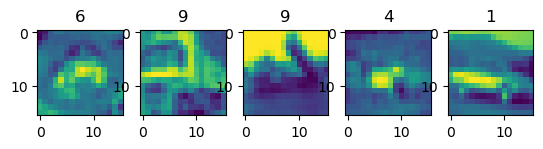

In [17]:
for i in range(5):
    ax = plt.subplot(1,5,i+1)
    img = train_loader.dataset[i][0]
    print(img.shape)
    ax.imshow(img.reshape(IMG_SHAPE, IMG_SHAPE,-1))
    ax.title.set_text(int(train_loader.dataset[i][1]))
plt.show()

### Small Model - 3 Layers 

In [18]:
small_model = LinearModelSmall(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [19]:
small_model.to(device)

LinearModelSmall(
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
test(small_model,1,test_loader)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(small_model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [130]:
n_epochs = 30

losses, val_acc, prof, grad_metrics = train(small_model, n_epochs, optimizer, scheduler, False, train_loader, test_loader)


/Users/amogh/miniforge3/envs/py312/lib/python3.12/site-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


Epoch  0  : 
 Val Acc =  0.2546  Loss =  1.976209282875061 Epoch time =  14.364
Epoch  1  : 
 Val Acc =  0.2356  Loss =  1.8036168813705444 Epoch time =  14.423
Epoch  2  : 
 Val Acc =  0.255  Loss =  2.1352272033691406 Epoch time =  15.757
Epoch  3  : 
 Val Acc =  0.2345  Loss =  1.9438369274139404 Epoch time =  15.507
Epoch  4  : 
 Val Acc =  0.2626  Loss =  2.042726516723633 Epoch time =  14.582
Epoch  5  : 
 Val Acc =  0.2541  Loss =  2.063892364501953 Epoch time =  15.057
Epoch  6  : 
 Val Acc =  0.253  Loss =  2.383035182952881 Epoch time =  15.63
Epoch  7  : 
 Val Acc =  0.2527  Loss =  2.013512134552002 Epoch time =  14.918
Epoch  8  : 
 Val Acc =  0.2607  Loss =  1.9062864780426025 Epoch time =  14.557
Epoch  9  : 
 Val Acc =  0.2422  Loss =  2.0048298835754395 Epoch time =  14.621
Epoch  10  : 
 Val Acc =  0.2776  Loss =  1.8505772352218628 Epoch time =  15.411
Epoch  11  : 
 Val Acc =  0.2765  Loss =  1.8166671991348267 Epoch time =  15.074
Epoch  12  : 
 Val Acc =  0.2788  

In [131]:
test(small_model, 1, test_loader)

0.2809

In [151]:
n_epoch = 30
n_runs = 3


### Training Large Model from scratch

In [157]:
large_model = LinearModelLargeFunction(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [158]:
large_model

LinearModelLargeFunction(
  (linear1): Linear(in_features=256, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1024, bias=True)
  (linear5): Linear(in_features=1024, out_features=10, bias=True)
)

In [159]:
test(large_model, 1, test_loader)

0.1133

In [160]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(large_model.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [161]:
comp_losses_ref = []
comp_val_acc_ref = []
for i in range(n_runs):
    losses_, val_acc_, prof_, grad_metrics_ = train(small_model, n_epochs, optimizer, scheduler, False, train_loader, test_loader)
    comp_losses_ref.append(losses_)
    comp_val_acc_ref.append(val_acc_)

/Users/amogh/miniforge3/envs/py312/lib/python3.12/site-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


Epoch  0  : 
 Val Acc =  0.2809  Loss =  2.0281240940093994 Epoch time =  12.247
Epoch  1  : 
 Val Acc =  0.2809  Loss =  2.0532426834106445 Epoch time =  11.878
Epoch  2  : 
 Val Acc =  0.2809  Loss =  1.9999761581420898 Epoch time =  11.934
Epoch  3  : 
 Val Acc =  0.2809  Loss =  2.106670379638672 Epoch time =  11.853
Epoch  4  : 
 Val Acc =  0.2809  Loss =  1.8206290006637573 Epoch time =  11.593
Epoch  5  : 
 Val Acc =  0.2809  Loss =  2.0081844329833984 Epoch time =  11.785
Epoch  6  : 
 Val Acc =  0.2809  Loss =  1.8825905323028564 Epoch time =  12.016
Epoch  7  : 
 Val Acc =  0.2809  Loss =  1.9019300937652588 Epoch time =  12.326
Epoch  8  : 
 Val Acc =  0.2809  Loss =  1.8371957540512085 Epoch time =  11.805
Epoch  9  : 
 Val Acc =  0.2809  Loss =  2.0220744609832764 Epoch time =  11.721
Epoch  10  : 
 Val Acc =  0.2809  Loss =  2.002699851989746 Epoch time =  11.941
Epoch  11  : 
 Val Acc =  0.2809  Loss =  2.0932116508483887 Epoch time =  11.899
Epoch  12  : 
 Val Acc =  0.

### Training model using reverse KD - Setting ratio of teacher model logits to labels loss to 1:1

In [162]:
large_model = LinearModelLargeFunction(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [163]:
test(large_model, 1, test_loader)

0.1005

In [164]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(large_model.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [165]:
n_epoch = 30
comp_losses_1 = []
comp_val_acc_1 = []
for i in range(n_runs):
    losses_, val_acc_ = expand_training(small_model, large_model, train_loader, test_loader, n_epoch, 1,1)
    comp_losses_1.append(losses_)
    comp_val_acc_1.append(val_acc_)

Epoch 1/30, Loss: 2.1237093288828257
Epoch 2/30, Loss: 2.022962224162953
Epoch 3/30, Loss: 2.011781079134166
Epoch 4/30, Loss: 2.0062637854935113
Epoch 5/30, Loss: 2.002461404028073
Epoch 6/30, Loss: 2.000492476165371
Epoch 7/30, Loss: 1.9957831682835285
Epoch 8/30, Loss: 1.9984666857005082
Epoch 9/30, Loss: 1.9963263998263625
Epoch 10/30, Loss: 1.994487631336217
Epoch 11/30, Loss: 1.9514000196768289
Epoch 12/30, Loss: 1.9489148151554005
Epoch 13/30, Loss: 1.9481482631723646
Epoch 14/30, Loss: 1.9474936956480127
Epoch 15/30, Loss: 1.947212141469865
Epoch 16/30, Loss: 1.9468771490946928
Epoch 17/30, Loss: 1.9466759020631963
Epoch 18/30, Loss: 1.9462475394317345
Epoch 19/30, Loss: 1.9453146743865997
Epoch 20/30, Loss: 1.9455717978343157
Epoch 21/30, Loss: 1.940294004814573
Epoch 22/30, Loss: 1.9397394579290275
Epoch 23/30, Loss: 1.9396445200934758
Epoch 24/30, Loss: 1.9394973292088233
Epoch 25/30, Loss: 1.9394570043389225
Epoch 26/30, Loss: 1.9392911447605616
Epoch 27/30, Loss: 1.9393344

### Setting ratio of teacher model logits to labels loss to 1:3

In [169]:
large_model = LinearModelLargeFunction(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [170]:
test(large_model, 1, test_loader)

0.1038

In [171]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(large_model.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [172]:
n_epoch = 30
comp_losses_2 = []
comp_val_acc_2 = []
for i in range(n_runs):
    losses_, val_acc_ = expand_training(small_model, large_model, train_loader, test_loader, n_epoch, 1,3)
    comp_losses_2.append(losses_)
    comp_val_acc_2.append(val_acc_)

Epoch 1/30, Loss: 6.27663142702491
Epoch 2/30, Loss: 6.055042183200773
Epoch 3/30, Loss: 6.036285403138086
Epoch 4/30, Loss: 6.009207703850486
Epoch 5/30, Loss: 6.006890457815153
Epoch 6/30, Loss: 6.003032486508964
Epoch 7/30, Loss: 5.99251510513882
Epoch 8/30, Loss: 5.999350036762741
Epoch 9/30, Loss: 6.006356966785524
Epoch 10/30, Loss: 5.992356027744797
Epoch 11/30, Loss: 5.855774469473298
Epoch 12/30, Loss: 5.841720918381871
Epoch 13/30, Loss: 5.838488572385644
Epoch 14/30, Loss: 5.832696048306747
Epoch 15/30, Loss: 5.828788934993377
Epoch 16/30, Loss: 5.830669834427583
Epoch 17/30, Loss: 5.827192913096937
Epoch 18/30, Loss: 5.826351674662357
Epoch 19/30, Loss: 5.824934971927833
Epoch 20/30, Loss: 5.821974882853627
Epoch 21/30, Loss: 5.806667756790083
Epoch 22/30, Loss: 5.804110488574117
Epoch 23/30, Loss: 5.803998828392175
Epoch 24/30, Loss: 5.803902607415916
Epoch 25/30, Loss: 5.803477183194228
Epoch 26/30, Loss: 5.803740683957343
Epoch 27/30, Loss: 5.802945882196463
Epoch 28/30,

In [173]:
test(large_model,1,test_loader)

0.2845

### Setting ratio of teacher model logits to labels loss to 3:1

In [174]:
large_model = LinearModelLargeFunction(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [175]:
test(large_model, 1, test_loader)

0.1

In [176]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(large_model.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [177]:
n_epoch = 30
comp_losses_3 = []
comp_val_acc_3 = []
for i in range(n_runs):
    losses_, val_acc_ = expand_training(small_model, large_model, train_loader, test_loader, n_epoch, 3,1)
    comp_losses_3.append(losses_)
    comp_val_acc_3.append(val_acc_)

Epoch 1/30, Loss: 2.235359349415641
Epoch 2/30, Loss: 2.0247110074216668
Epoch 3/30, Loss: 2.0095891407601507
Epoch 4/30, Loss: 2.0001255392875623
Epoch 5/30, Loss: 1.9994947539401573
Epoch 6/30, Loss: 1.997591317386847
Epoch 7/30, Loss: 1.9936111844913909
Epoch 8/30, Loss: 1.9943755829227414
Epoch 9/30, Loss: 1.9938957996466096
Epoch 10/30, Loss: 1.9943748419477143
Epoch 11/30, Loss: 1.949576307121526
Epoch 12/30, Loss: 1.948090094076076
Epoch 13/30, Loss: 1.947985102135149
Epoch 14/30, Loss: 1.948065397986682
Epoch 15/30, Loss: 1.9478159117179705
Epoch 16/30, Loss: 1.948219867735605
Epoch 17/30, Loss: 1.947873215745567
Epoch 18/30, Loss: 1.947619171972922
Epoch 19/30, Loss: 1.9479332115982926
Epoch 20/30, Loss: 1.9478120855729497
Epoch 21/30, Loss: 1.9431358985650555
Epoch 22/30, Loss: 1.9425800333560352
Epoch 23/30, Loss: 1.9425237088746816
Epoch 24/30, Loss: 1.9426871974703293
Epoch 25/30, Loss: 1.9425789847416701
Epoch 26/30, Loss: 1.9426293033491175
Epoch 27/30, Loss: 1.942600725

In [178]:
test(large_model,1,test_loader)

0.2831

### Setting ratio of teacher model logits to labels loss to 1:5

In [179]:
large_model = LinearModelLargeFunction(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [180]:
test(large_model, 1, test_loader)

0.0904

In [181]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(large_model.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [182]:
n_epoch = 30
comp_losses_4 = []
comp_val_acc_4 = []
for i in range(n_runs):
    losses_, val_acc_ = expand_training(small_model, large_model, train_loader, test_loader, n_epoch, 1,5)
    comp_losses_4.append(losses_)
    comp_val_acc_4.append(val_acc_)

Epoch 1/30, Loss: 10.956963481732123
Epoch 2/30, Loss: 10.666478564888811
Epoch 3/30, Loss: 10.615868870030598
Epoch 4/30, Loss: 10.587926255908727
Epoch 5/30, Loss: 10.589514372748694
Epoch 6/30, Loss: 10.567694669496387
Epoch 7/30, Loss: 10.569591892818789
Epoch 8/30, Loss: 10.564698232731349
Epoch 9/30, Loss: 10.558911545786449
Epoch 10/30, Loss: 10.548901934019277
Epoch 11/30, Loss: 10.443204395597022
Epoch 12/30, Loss: 10.434753459485941
Epoch 13/30, Loss: 10.432182579431277
Epoch 14/30, Loss: 10.430846333961634
Epoch 15/30, Loss: 10.429653280065246
Epoch 16/30, Loss: 10.42884044610584
Epoch 17/30, Loss: 10.426114700820474
Epoch 18/30, Loss: 10.427189160858623
Epoch 19/30, Loss: 10.426370155490773
Epoch 20/30, Loss: 10.426026039025848
Epoch 21/30, Loss: 10.412820973561148
Epoch 22/30, Loss: 10.411825532339295
Epoch 23/30, Loss: 10.412072902147047
Epoch 24/30, Loss: 10.411158246664323
Epoch 25/30, Loss: 10.411243098035513
Epoch 26/30, Loss: 10.410516457429463
Epoch 27/30, Loss: 10.

In [183]:
test(large_model,1,test_loader)

0.2364

### Setting ratio of teacher model logits to labels loss to 5:1

In [184]:
large_model = LinearModelLargeFunction(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [185]:
test(large_model, 1, test_loader)

0.0884

In [186]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(large_model.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [187]:
n_epoch = 30
comp_losses_5 = []
comp_val_acc_5 = []
for i in range(n_runs):
    losses_, val_acc_ = expand_training(small_model, large_model, train_loader, test_loader, n_epoch, 5,1)
    comp_losses_5.append(losses_)
    comp_val_acc_5.append(val_acc_)

Epoch 1/30, Loss: 2.231983361262518
Epoch 2/30, Loss: 2.034791626789811
Epoch 3/30, Loss: 2.0127521532751076
Epoch 4/30, Loss: 2.0026136626049436
Epoch 5/30, Loss: 1.9971373297188255
Epoch 6/30, Loss: 1.996480489967727
Epoch 7/30, Loss: 1.995913850513219
Epoch 8/30, Loss: 1.9936707924941743
Epoch 9/30, Loss: 1.9918480337658246
Epoch 10/30, Loss: 1.9896553831888069
Epoch 11/30, Loss: 1.9489620018096954
Epoch 12/30, Loss: 1.9482206328272362
Epoch 13/30, Loss: 1.9481971979751782
Epoch 14/30, Loss: 1.9481230211776899
Epoch 15/30, Loss: 1.9477167178360357
Epoch 16/30, Loss: 1.9484229972359466
Epoch 17/30, Loss: 1.9477014215746549
Epoch 18/30, Loss: 1.9481779770417647
Epoch 19/30, Loss: 1.9480682803024556
Epoch 20/30, Loss: 1.9478826109181597
Epoch 21/30, Loss: 1.943195105209546
Epoch 22/30, Loss: 1.9428649755354575
Epoch 23/30, Loss: 1.9427171099201208
Epoch 24/30, Loss: 1.9428310482816415
Epoch 25/30, Loss: 1.9428576215739135
Epoch 26/30, Loss: 1.942625932824749
Epoch 27/30, Loss: 1.942565

In [190]:
comp_losses_arr = [comp_losses_ref, comp_losses_1, comp_losses_2, comp_losses_3, comp_losses_4, comp_losses_5]
val_acc_arr = [comp_val_acc_ref, comp_val_acc_1, comp_val_acc_2, comp_val_acc_3, comp_val_acc_4, comp_val_acc_5]

In [191]:
save_var_pickle(comp_losses_arr, "PickleFiles", "comp_losses_rev_KD")

In [193]:
save_var_pickle(val_acc_arr, "PickleFiles", "comp_val_acc_rev_KD")

In [264]:
with open('PickleFiles/comp_losses_rev_KD.pkl', 'rb') as file:
	comp_losses_arr = pickle.load(file)

In [265]:
with open('PickleFiles/comp_val_acc_rev_KD.pkl', 'rb') as file:
	val_acc_arr = pickle.load(file)

## Analysis

The models are each trained for 3 runs, where each run a new model is instantiated and trained for 30 epochs on the dataset. The accuracy and loss from this training is stored and analysed below.

In [376]:
labels = ["Reference", "1:1" , "1:3", "3:1", "1:5", "5:1"]
formatted_val_acc = []
formatted_loss = []
val_acc_variance = []
loss_variance = []
for i in range(len(labels)):
    formatted_val_acc.append(np.sum(np.array(val_acc_arr[i]),axis=0) / n_runs)
    val_acc_variance.append(np.var(val_acc_arr[i], axis=0))
    
    formatted_loss.append(np.sum(np.array(comp_losses_arr[i]),axis=0) / n_runs)
    loss_variance.append(np.var(comp_losses_arr[i],axis=0))


temp = []
for i in range(30):
    temp.append(formatted_loss[0][1562*i])
formatted_loss[0] = temp

In [377]:
def format_append(mu, var):
    return str(round(mu,3))+"±"+str(round(var,3))

In [378]:
table = PrettyTable()
header_row = ["Model","First Epoch Loss" , "Last Epoch Loss", "First Epoch Accuracy", "Last Epoch Accuracy"]
table_rows = []
for i in range(len(labels)):
    vals = [
        labels[i],
        format_append(formatted_loss[i][0], loss_variance[i][0]),
        format_append(formatted_loss[i][-1], loss_variance[i][-1]),
        format_append(formatted_val_acc[i][0], val_acc_variance[i][0]),
        format_append(formatted_val_acc[i][-1], val_acc_variance[i][-1]),
    ]
    table_rows.append(vals)
table.field_names = header_row
table.add_rows(table_rows)

In [379]:
print("Summary of runs")
print(table)

Summary of runs
+-----------+------------------+-----------------+----------------------+---------------------+
|   Model   | First Epoch Loss | Last Epoch Loss | First Epoch Accuracy | Last Epoch Accuracy |
+-----------+------------------+-----------------+----------------------+---------------------+
| Reference |   1.925±0.001    |   2.025±0.001   |      0.281±0.0       |      0.281±0.0      |
|    1:1    |   2.038±0.004    |     1.94±0.0    |       0.27±0.0       |      0.284±0.0      |
|    1:3    |    6.078±0.02    |    5.805±0.0    |      0.259±0.0       |      0.286±0.0      |
|    3:1    |   2.072±0.013    |    1.942±0.0    |      0.274±0.0       |      0.283±0.0      |
|    1:5    |   10.676±0.04    |    10.411±0.0   |      0.224±0.0       |      0.237±0.0      |
|    5:1    |   2.071±0.013    |    1.943±0.0    |      0.275±0.0       |      0.283±0.0      |
+-----------+------------------+-----------------+----------------------+---------------------+


Due to the simple nature of the models, the accuracy is quite low but an analysis can still be drawn from the data.

The table above shows that the models with a higher weightage on the logits output (small model outputs) were able to perform better than the other configurations. Ratios of 3:1 and 5: outperformed ratios 1:3 and 1:5 in the last epoch loss and the last epoch accuracy. The models trained using 5:1 and 3:1 ratios also had a lower last epoch loss compared to the baseline where the entire model is trained without a reference model. This can denote that by emphasizing slightly more on the outputs of the pre-trained model, it is possible to gain better performance during the training of a larger model. 

The results show that it is possible to impart knowledge from the smaller model to a larger model during training and extract an advantage in performance.

The two loss plots below show that the reference, 1:1, 3:1 and 5:1 models had the lowest losses. 1:5 and 1:3 models had the worst loss.  

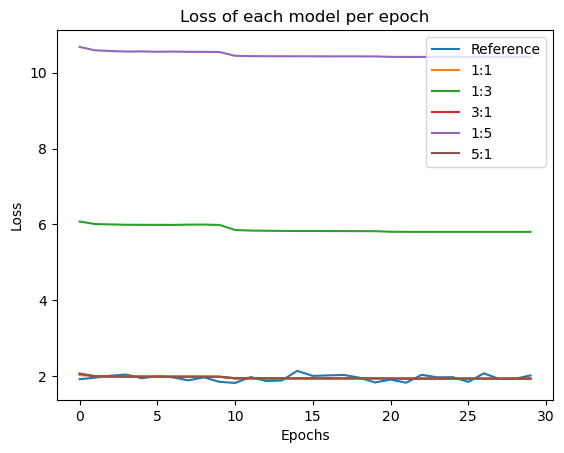

In [380]:
for i in range(len(formatted_loss)):
    plt.plot(formatted_loss[i], label=labels[i])
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of each model per epoch")
plt.show()

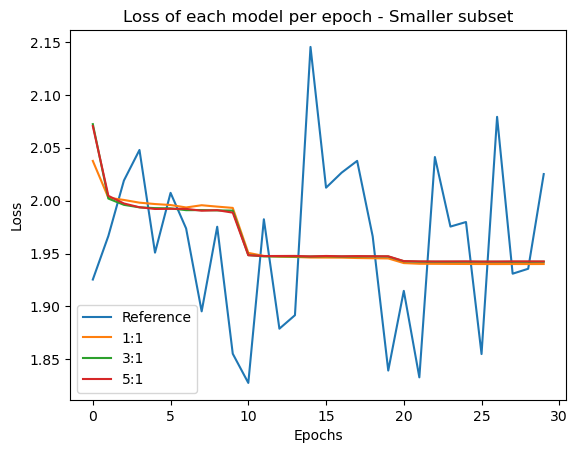

In [383]:
shortened = [formatted_loss[0], formatted_loss[1], formatted_loss[3], formatted_loss[5]]
shortened_labels = [labels[0], labels[1], labels[3], labels[5]]

for i in range(len(shortened)):
    plt.plot(shortened[i], label=shortened_labels[i])
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of each model per epoch - Smaller subset")
plt.show()

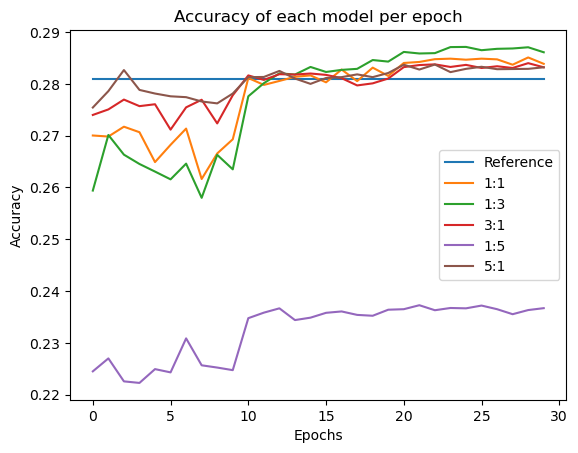

In [382]:
for i in range(len(formatted_val_acc)):
    plt.plot(formatted_val_acc[i], label=labels[i])
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of each model per epoch")
plt.show()

From these results, it can be seen that reverse knowledge distillation can be useful for training larger models given smaller pre-trained models. Due to the simplicity of the models, the results were not very high but it can be a useful starting point. In further experiments, we can test other methods for reverse knowledge distillation and study them on better, more comprehensive models.

## MNIST

In [20]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


In [30]:
IMG_SHAPE = 32

training_data = datasets.FashionMNIST(
    root="data/FashionMNIST",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        # transforms.Grayscale(),
        transforms.Resize((IMG_SHAPE, IMG_SHAPE)),
        AddGaussianNoise(0,0.2)
    ])
)

test_data = datasets.FashionMNIST(
    root="data/FashionMNIST",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        # transforms.Grayscale(),
        transforms.Resize((IMG_SHAPE, IMG_SHAPE)),
        AddGaussianNoise(0,0.2)
        
    ])
)

generator = torch.Generator().manual_seed(1213442)

In [31]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=32, shuffle=True, generator=generator, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, generator=generator, drop_last=True)

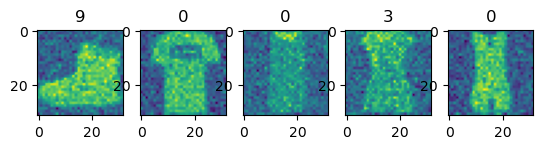

In [32]:
for i in range(5):
    ax = plt.subplot(1,5,i+1)
    img = train_loader.dataset[i][0]
    ax.imshow(img.reshape(IMG_SHAPE, IMG_SHAPE,-1))
    ax.title.set_text(int(train_loader.dataset[i][1]))
plt.show()

### Small Model - 3 Layers 

In [56]:
small_model = LinearModelSmall(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [57]:
small_model.to(device)

LinearModelSmall(
  (linear1): Linear(in_features=1024, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=10, bias=True)
)

In [58]:
test(small_model,1,test_loader)

0.1005

In [59]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(small_model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [60]:
n_epochs = 10

losses, val_acc, prof, grad_metrics = train(small_model, n_epochs, optimizer, scheduler, False, train_loader, test_loader)


Epoch  0  : 
 Val Acc =  0.8111  Loss =  0.43911945819854736 Epoch time =  16.93
Epoch  1  : 
 Val Acc =  0.8402  Loss =  0.5331143140792847 Epoch time =  17.656
Epoch  2  : 
 Val Acc =  0.8458  Loss =  0.38866180181503296 Epoch time =  17.813
Epoch  3  : 
 Val Acc =  0.8415  Loss =  0.3509137034416199 Epoch time =  17.372
Epoch  4  : 
 Val Acc =  0.8534  Loss =  0.4644545316696167 Epoch time =  16.681
Epoch  5  : 
 Val Acc =  0.862  Loss =  0.4536769986152649 Epoch time =  16.411
Epoch  6  : 
 Val Acc =  0.8637  Loss =  0.27937057614326477 Epoch time =  16.461
Epoch  7  : 
 Val Acc =  0.866  Loss =  0.17433519661426544 Epoch time =  16.501
Epoch  8  : 
 Val Acc =  0.8654  Loss =  0.2336864471435547 Epoch time =  16.498
Epoch  9  : 
 Val Acc =  0.8658  Loss =  0.23143857717514038 Epoch time =  16.43


In [61]:
test(small_model, 1, test_loader)

0.8645

In [81]:
n_epoch = 10
n_runs = 3


### Training Large Model from scratch

In [63]:
large_model = LinearModelLargeFunction(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [64]:
large_model

LinearModelLargeFunction(
  (linear1): Linear(in_features=1024, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=10, bias=True)
)

In [65]:
test(large_model, 1, test_loader)

0.0768

In [66]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(large_model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [67]:
comp_losses_ref = []
comp_val_acc_ref = []
for i in range(n_runs):
    losses_, val_acc_, prof_, grad_metrics_ = train(small_model, n_epochs, optimizer, scheduler, False, train_loader, test_loader)
    comp_losses_ref.append(losses_)
    comp_val_acc_ref.append(val_acc_)

Epoch  0  : 
 Val Acc =  0.8644  Loss =  0.19935913383960724 Epoch time =  13.194
Epoch  1  : 
 Val Acc =  0.8642  Loss =  0.5979503989219666 Epoch time =  13.299
Epoch  2  : 
 Val Acc =  0.8633  Loss =  0.10343647003173828 Epoch time =  13.309
Epoch  3  : 
 Val Acc =  0.864  Loss =  0.38614463806152344 Epoch time =  13.281
Epoch  4  : 
 Val Acc =  0.8661  Loss =  0.3249020576477051 Epoch time =  13.754
Epoch  5  : 
 Val Acc =  0.867  Loss =  0.18629512190818787 Epoch time =  13.908
Epoch  6  : 
 Val Acc =  0.8678  Loss =  0.3028176724910736 Epoch time =  14.387
Epoch  7  : 
 Val Acc =  0.8669  Loss =  0.2526460886001587 Epoch time =  12.915
Epoch  8  : 
 Val Acc =  0.8653  Loss =  0.4269982874393463 Epoch time =  15.364
Epoch  9  : 
 Val Acc =  0.8624  Loss =  0.3628179728984833 Epoch time =  13.554
Epoch  0  : 
 Val Acc =  0.864  Loss =  0.23093348741531372 Epoch time =  12.99
Epoch  1  : 
 Val Acc =  0.8621  Loss =  0.1843634992837906 Epoch time =  13.287
Epoch  2  : 
 Val Acc =  0.

### Training model using reverse KD - Setting ratio of teacher model logits to labels loss to 1:1

In [82]:
large_model = LinearModelLargeFunction(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [83]:
test(large_model, 1, test_loader)

0.0903

In [84]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(large_model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [86]:
comp_losses_1 = []
comp_val_acc_1 = []
for i in range(n_runs):
    losses_, val_acc_ = expand_training(small_model, large_model, train_loader, test_loader, n_epoch, 1,1)
    comp_losses_1.append(losses_)
    comp_val_acc_1.append(val_acc_)

Epoch 1/10, Loss: 0.8166539387464523
Epoch 2/10, Loss: 0.6336318262815476
Epoch 3/10, Loss: 0.6092414533058802
Epoch 4/10, Loss: 0.590318222562472
Epoch 5/10, Loss: 0.5781913853049279
Epoch 6/10, Loss: 0.5771562119325002
Epoch 7/10, Loss: 0.5649459919293721
Epoch 8/10, Loss: 0.5699637642820676
Epoch 9/10, Loss: 0.5650927751580874
Epoch 10/10, Loss: 0.55268528718551
Epoch 1/10, Loss: 0.5656256010770798
Epoch 2/10, Loss: 0.5540467357635498
Epoch 3/10, Loss: 0.555321336332957
Epoch 4/10, Loss: 0.5425125768224398
Epoch 5/10, Loss: 0.5461125643253326
Epoch 6/10, Loss: 0.5490728198846181
Epoch 7/10, Loss: 0.5382735414703687
Epoch 8/10, Loss: 0.5453037479956945
Epoch 9/10, Loss: 0.5447558110316595
Epoch 10/10, Loss: 0.5444285547216733
Epoch 1/10, Loss: 0.5462551821708679
Epoch 2/10, Loss: 0.5391764526009559
Epoch 3/10, Loss: 0.5398369865059852
Epoch 4/10, Loss: 0.5344631510655086
Epoch 5/10, Loss: 0.5406997734427452
Epoch 6/10, Loss: 0.5390218226830165
Epoch 7/10, Loss: 0.5294176657517751
Epo

### Setting ratio of teacher model logits to labels loss to 1:3

In [87]:
large_model = LinearModelLargeFunction(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [88]:
test(large_model, 1, test_loader)

0.076

In [89]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(large_model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [90]:
comp_losses_2 = []
comp_val_acc_2 = []
for i in range(n_runs):
    losses_, val_acc_ = expand_training(small_model, large_model, train_loader, test_loader, n_epoch, 1,3)
    comp_losses_2.append(losses_)
    comp_val_acc_2.append(val_acc_)

Epoch 1/10, Loss: 1.9992396866162618
Epoch 2/10, Loss: 1.691134122522672
Epoch 3/10, Loss: 1.6024423955599467
Epoch 4/10, Loss: 1.5538725907007853
Epoch 5/10, Loss: 1.5558028444449108
Epoch 6/10, Loss: 1.543104735660553
Epoch 7/10, Loss: 1.5386658799171449
Epoch 8/10, Loss: 1.5198315631548565
Epoch 9/10, Loss: 1.511283612124125
Epoch 10/10, Loss: 1.4959513734499614
Epoch 1/10, Loss: 1.5087175652503968
Epoch 2/10, Loss: 1.502281922721863
Epoch 3/10, Loss: 1.5079064675966898
Epoch 4/10, Loss: 1.478439785528183
Epoch 5/10, Loss: 1.5060307661533356
Epoch 6/10, Loss: 1.476933883714676
Epoch 7/10, Loss: 1.496550149901708
Epoch 8/10, Loss: 1.4809516671657563
Epoch 9/10, Loss: 1.4863318553606668
Epoch 10/10, Loss: 1.4732502810955048
Epoch 1/10, Loss: 1.4860909365653991
Epoch 2/10, Loss: 1.4808282228310903
Epoch 3/10, Loss: 1.471839437198639
Epoch 4/10, Loss: 1.4763232108751934
Epoch 5/10, Loss: 1.471916700299581
Epoch 6/10, Loss: 1.4845719823678334
Epoch 7/10, Loss: 1.4762969278971354
Epoch 8/

In [91]:
test(large_model,1,test_loader)

0.8248

### Setting ratio of teacher model logits to labels loss to 3:1

In [92]:
large_model = LinearModelLargeFunction(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [93]:
test(large_model, 1, test_loader)

0.0639

In [94]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(large_model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [95]:
comp_losses_3 = []
comp_val_acc_3 = []
for i in range(n_runs):
    losses_, val_acc_ = expand_training(small_model, large_model, train_loader, test_loader, n_epoch, 3,1)
    comp_losses_3.append(losses_)
    comp_val_acc_3.append(val_acc_)

Epoch 1/10, Loss: 1.190797148402532
Epoch 2/10, Loss: 0.8457924189090729
Epoch 3/10, Loss: 0.7945864206314087
Epoch 4/10, Loss: 0.7684534945646921
Epoch 5/10, Loss: 0.735477421951294
Epoch 6/10, Loss: 0.7212430221954982
Epoch 7/10, Loss: 0.7142918558478355
Epoch 8/10, Loss: 0.7075648030598959
Epoch 9/10, Loss: 0.7011717501004537
Epoch 10/10, Loss: 0.7028534027417501
Epoch 1/10, Loss: 0.7146886024157206
Epoch 2/10, Loss: 0.6955652578830719
Epoch 3/10, Loss: 0.692206824739774
Epoch 4/10, Loss: 0.6995741087436677
Epoch 5/10, Loss: 0.6937714194933573
Epoch 6/10, Loss: 0.6900520602146785
Epoch 7/10, Loss: 0.6726972607215246
Epoch 8/10, Loss: 0.6812591883182526
Epoch 9/10, Loss: 0.664443928718567
Epoch 10/10, Loss: 0.6830444322864214
Epoch 1/10, Loss: 0.6791986229499181
Epoch 2/10, Loss: 0.6681074448744456
Epoch 3/10, Loss: 0.6671425595680872
Epoch 4/10, Loss: 0.6701353748003642
Epoch 5/10, Loss: 0.6648024286270141
Epoch 6/10, Loss: 0.6745753975868225
Epoch 7/10, Loss: 0.6702967974821726
Epo

In [96]:
test(large_model,1,test_loader)

0.8475

### Setting ratio of teacher model logits to labels loss to 1:5

In [97]:
large_model = LinearModelLargeFunction(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [98]:
test(large_model, 1, test_loader)

0.1069

In [99]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(large_model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [100]:
comp_losses_4 = []
comp_val_acc_4 = []
for i in range(n_runs):
    losses_, val_acc_ = expand_training(small_model, large_model, train_loader, test_loader, n_epoch, 1,5)
    comp_losses_4.append(losses_)
    comp_val_acc_4.append(val_acc_)

Epoch 1/10, Loss: 3.2675639828364056
Epoch 2/10, Loss: 2.7010025387763976
Epoch 3/10, Loss: 2.588466107813517
Epoch 4/10, Loss: 2.5412571220318476
Epoch 5/10, Loss: 2.513025731722514
Epoch 6/10, Loss: 2.4882138015270234
Epoch 7/10, Loss: 2.472900048605601
Epoch 8/10, Loss: 2.447120174217224
Epoch 9/10, Loss: 2.481720727443695
Epoch 10/10, Loss: 2.4170128121376036
Epoch 1/10, Loss: 2.454401798613866
Epoch 2/10, Loss: 2.446707112073898
Epoch 3/10, Loss: 2.4390561672369637
Epoch 4/10, Loss: 2.4229259952068327
Epoch 5/10, Loss: 2.4051715555985766
Epoch 6/10, Loss: 2.410894724988937
Epoch 7/10, Loss: 2.3969860206604006
Epoch 8/10, Loss: 2.440022573566437
Epoch 9/10, Loss: 2.4322269350687664
Epoch 10/10, Loss: 2.415688278722763
Epoch 1/10, Loss: 2.437706735897064
Epoch 2/10, Loss: 2.3821053880055745
Epoch 3/10, Loss: 2.387188619931539
Epoch 4/10, Loss: 2.3986226424217225
Epoch 5/10, Loss: 2.3862786768595377
Epoch 6/10, Loss: 2.389784813928604
Epoch 7/10, Loss: 2.346058799346288
Epoch 8/10, L

In [101]:
test(large_model,1,test_loader)

0.8301

### Setting ratio of teacher model logits to labels loss to 5:1

In [102]:
large_model = LinearModelLargeFunction(IMG_SHAPE**2, output_size=len(training_data.classes), batch_size=train_loader.batch_size)

In [103]:
test(large_model, 1, test_loader)

0.1064

In [104]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(large_model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [105]:
comp_losses_5 = []
comp_val_acc_5 = []
for i in range(n_runs):
    losses_, val_acc_ = expand_training(small_model, large_model, train_loader, test_loader, n_epoch, 5,1)
    comp_losses_5.append(losses_)
    comp_val_acc_5.append(val_acc_)

Epoch 1/10, Loss: 1.646485228951772
Epoch 2/10, Loss: 1.1193518432855607
Epoch 3/10, Loss: 1.0568102717638015
Epoch 4/10, Loss: 1.0195242616176605
Epoch 5/10, Loss: 0.9852027827580769
Epoch 6/10, Loss: 0.9642179504712423
Epoch 7/10, Loss: 0.9970466708819071
Epoch 8/10, Loss: 0.9099523009061813
Epoch 9/10, Loss: 0.9198036045710246
Epoch 10/10, Loss: 0.906163081741333
Epoch 1/10, Loss: 0.9616112030347188
Epoch 2/10, Loss: 0.9154360173940659
Epoch 3/10, Loss: 0.8942882590055465
Epoch 4/10, Loss: 0.9241314309914906
Epoch 5/10, Loss: 0.9020691163142522
Epoch 6/10, Loss: 0.9004123792250951
Epoch 7/10, Loss: 0.8769719896952312
Epoch 8/10, Loss: 0.8742488001982371
Epoch 9/10, Loss: 0.8702056057691574
Epoch 10/10, Loss: 0.8785612359364827
Epoch 1/10, Loss: 0.8792182473421096
Epoch 2/10, Loss: 0.8457872117201487
Epoch 3/10, Loss: 0.8535721213062605
Epoch 4/10, Loss: 0.8536618563095728
Epoch 5/10, Loss: 0.8510872877597809
Epoch 6/10, Loss: 0.8425873022158941
Epoch 7/10, Loss: 0.8472705971479416
E

In [106]:
comp_losses_arr = [comp_losses_ref, comp_losses_1, comp_losses_2, comp_losses_3, comp_losses_4, comp_losses_5]
val_acc_arr = [comp_val_acc_ref, comp_val_acc_1, comp_val_acc_2, comp_val_acc_3, comp_val_acc_4, comp_val_acc_5]

In [107]:
save_var_pickle(comp_losses_arr, "PickleFiles", "comp_losses_rev_KD_MNIST")

In [108]:
save_var_pickle(val_acc_arr, "PickleFiles", "comp_val_acc_rev_KD_MNIST")

In [18]:
with open('PickleFiles/comp_losses_rev_KD_MNIST.pkl', 'rb') as file:
	comp_losses_arr = pickle.load(file)

In [19]:
with open('PickleFiles/comp_val_acc_rev_KD_MNIST.pkl', 'rb') as file:
	val_acc_arr = pickle.load(file)

## Analysis

The models are each trained for 3 runs, where each run a new model is instantiated and trained for 30 epochs on the dataset. The accuracy and loss from this training is stored and analysed below.

In [20]:
n_runs = 3

In [21]:
labels = ["Reference", "1:1" , "1:3", "3:1", "1:5", "5:1"]
formatted_val_acc = []
formatted_loss = []
val_acc_variance = []
loss_variance = []
for i in range(len(labels)):
    formatted_val_acc.append(np.sum(np.array(val_acc_arr[i]),axis=0) / n_runs)
    val_acc_variance.append(np.var(val_acc_arr[i], axis=0))
    
    formatted_loss.append(np.sum(np.array(comp_losses_arr[i]),axis=0) / n_runs)
    loss_variance.append(np.var(comp_losses_arr[i],axis=0))


temp = []
for i in range(10):
    temp.append(formatted_loss[0][1875*i])
formatted_loss[0] = temp

In [22]:
def format_append(mu, var):
    return str(round(mu,3))+"±"+str(round(var,3))

In [23]:
table = PrettyTable()
header_row = ["Model","First Epoch Loss" , "Last Epoch Loss", "First Epoch Accuracy", "Last Epoch Accuracy"]
table_rows = []
for i in range(len(labels)):
    vals = [
        labels[i],
        format_append(formatted_loss[i][0], loss_variance[i][0]),
        format_append(formatted_loss[i][-1], loss_variance[i][-1]),
        format_append(formatted_val_acc[i][0], val_acc_variance[i][0]),
        format_append(formatted_val_acc[i][-1], val_acc_variance[i][-1]),
    ]
    table_rows.append(vals)
table.field_names = header_row
table.add_rows(table_rows)

In [24]:
print("Summary of runs")
print(table)

Summary of runs
+-----------+------------------+-----------------+----------------------+---------------------+
|   Model   | First Epoch Loss | Last Epoch Loss | First Epoch Accuracy | Last Epoch Accuracy |
+-----------+------------------+-----------------+----------------------+---------------------+
| Reference |   0.231±0.017    |    0.32±0.001   |      0.864±0.0       |      0.866±0.0      |
|    1:1    |   0.643±0.015    |    0.544±0.0    |      0.822±0.0       |      0.829±0.0      |
|    1:3    |   1.665±0.056    |    1.475±0.0    |      0.823±0.0       |      0.828±0.0      |
|    3:1    |   0.862±0.054    |    0.684±0.0    |       0.83±0.0       |      0.845±0.0      |
|    1:5    |    2.72±0.15     |    2.402±0.0    |      0.814±0.0       |      0.827±0.0      |
|    5:1    |   1.162±0.118    |   0.871±0.001   |      0.831±0.0       |      0.838±0.0      |
+-----------+------------------+-----------------+----------------------+---------------------+


In [43]:
df = pd.DataFrame(table.rows, columns=table.field_names)
df = df.sort_values(by='Last Epoch Accuracy', ascending=False)
colors_1 = ['#FF6A00' if x[0] == "Reference" else 'lightcyan' for x in df.to_numpy()]

In [49]:
df.columns

Index(['Model', 'First Epoch Loss', 'Last Epoch Loss', 'First Epoch Accuracy',
       'Last Epoch Accuracy'],
      dtype='object')

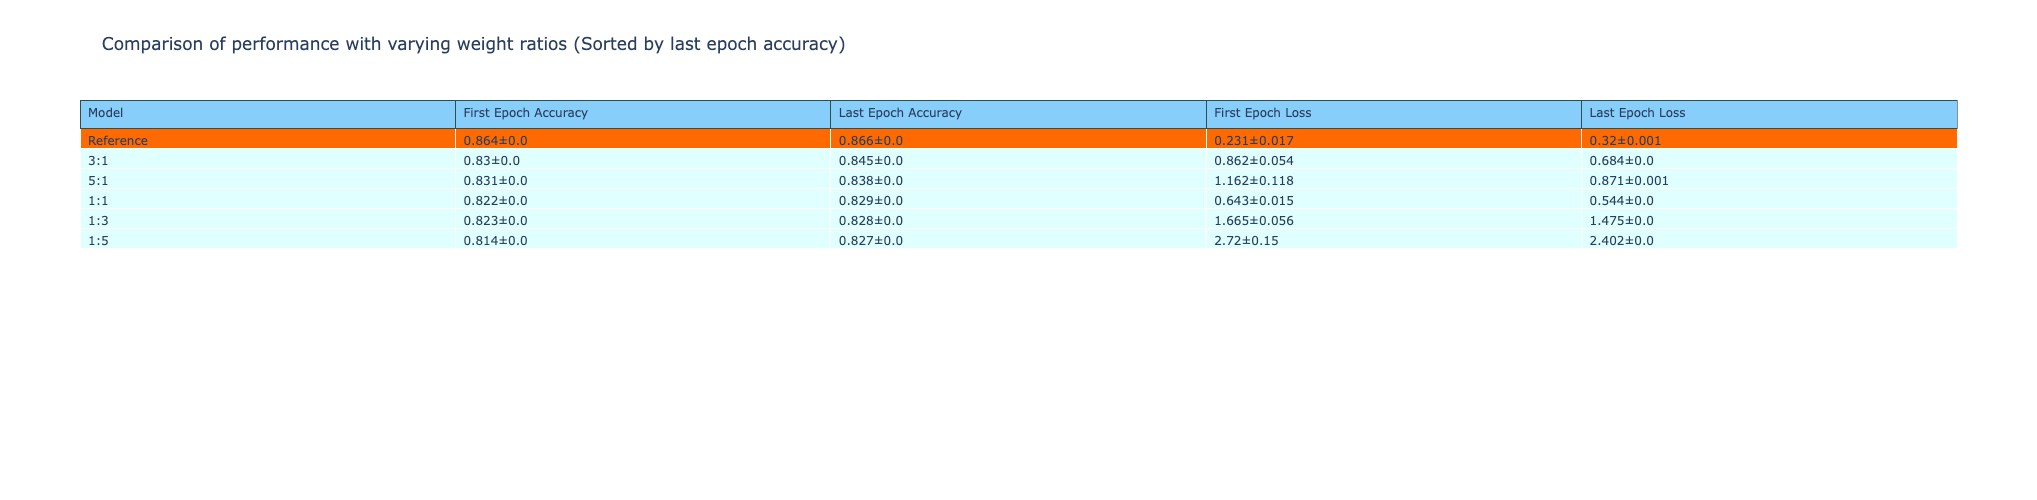

In [50]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Model', 'First Epoch Accuracy','Last Epoch Accuracy',  'First Epoch Loss', 'Last Epoch Loss'],
                align='left',
                line_color='darkslategray',
                fill_color='lightskyblue'),
    cells=dict(values=[df["Model"], df["First Epoch Accuracy"], df["Last Epoch Accuracy"], df["First Epoch Loss"], df["Last Epoch Loss"]],
               align='left',
               line_color='white',
               fill_color=[colors_1]
              
              ))
])

fig.update_layout(
    height=500,
    width=1000,
    title="Comparison of performance with varying weight ratios (Sorted by last epoch accuracy)"
)

fig.show()

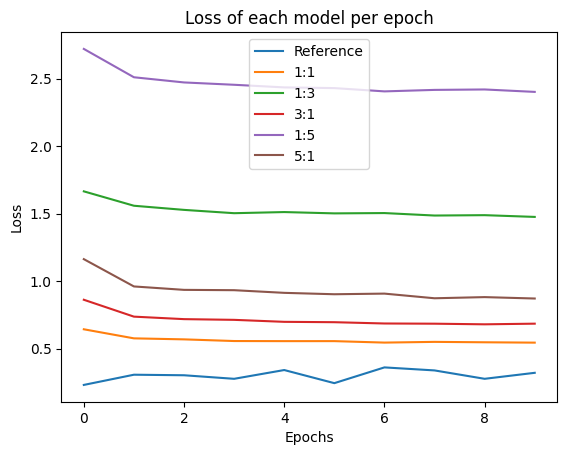

In [25]:
for i in range(len(formatted_loss)):
    plt.plot(formatted_loss[i], label=labels[i])
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of each model per epoch")
plt.show()

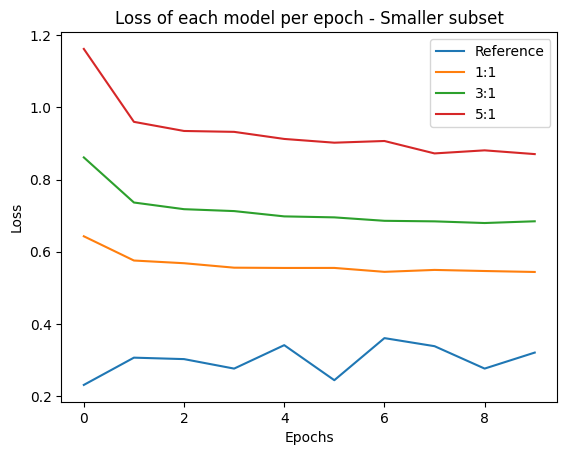

In [26]:
shortened = [formatted_loss[0], formatted_loss[1], formatted_loss[3], formatted_loss[5]]
shortened_labels = [labels[0], labels[1], labels[3], labels[5]]

for i in range(len(shortened)):
    plt.plot(shortened[i], label=shortened_labels[i])
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss of each model per epoch - Smaller subset")
plt.show()

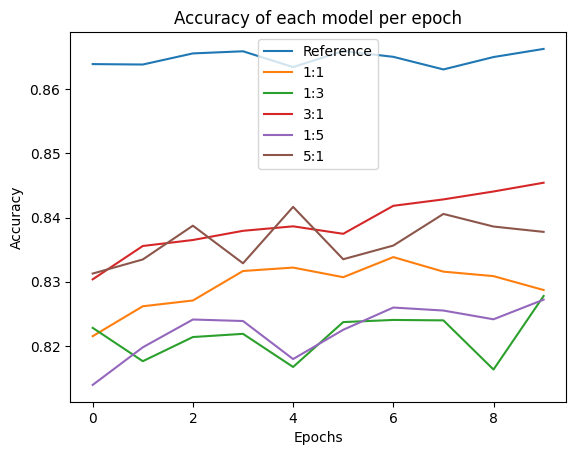

In [27]:
for i in range(len(formatted_val_acc)):
    plt.plot(formatted_val_acc[i], label=labels[i])
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of each model per epoch")
plt.show()